In [1]:
import logging
import sys

logging.basicConfig(
    stream=sys.stdout,
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt="%H:%M:%S",
)

%load_ext autoreload
%autoreload 2

# Pretrained model

In [3]:
from microgpt import Model, PretrainedModelConfig

model = await Model.load(
    config=PretrainedModelConfig(),
)
model

23:50:55 Pretrained model file size: 501099710 bytes
23:50:55 Loading pretrained model: config=type='custom_trained' dir_path='/Users/gpahal/Developer/python/projects/microgpt/pretrained/model'
23:50:55 Loading custom trained tokenizer: config=type='custom_trained' dir_path='/Users/gpahal/Developer/python/projects/microgpt/pretrained/model'
23:50:55 Loaded custom trained tokenizer: tokenizer=Tokenizer(
  split_pattern=[^\r\n\p{L}\p{N}]?[\p{Lu}\p{Lt}\p{Lm}\p{Lo}\p{M}]*[\p{Ll}\p{Lm}\p{Lo}\p{M}]+(?i:'s|'t|'re|'ve|'m|'ll|'d)?|[^\r\n\p{L}\p{N}]?[\p{Lu}\p{Lt}\p{Lm}\p{Lo}\p{M}]+[\p{Ll}\p{Lm}\p{Lo}\p{M}]*(?i:'s|'t|'re|'ve|'m|'ll|'d)?|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n/]*|\s*[\r\n]+|\s+(?!\S)|\s+
  special_tokens={'<|endoftext|>': 50256}
  eot_id=50256
  merges_size=50000
  vocab_size=50257
)
23:50:55 Loading pretrained model params: file_path=/Users/gpahal/Developer/python/projects/microgpt/pretrained/model/model.json
23:50:55 Loaded pretrained model params: params={'max_seq_len': 1024, 'd_mod

Model(
  device=cpu
  params={'max_seq_len': 1024, 'd_model': 768, 'n_layers': 12, 'n_heads': 12, 'use_padded_vocab_size': True, 'use_rope': True, 'rope_theta': 10000.0, 'is_rope_full_precision': True, 'embd_dropout_p': 0.0, 'attn_dropout_p': 0.0, 'residual_dropout_p': 0.0, 'init_std': 0.02, 'init_residual_scaled_factor': 2.0}
  tokenizer=Tokenizer(
  split_pattern=[^\r\n\p{L}\p{N}]?[\p{Lu}\p{Lt}\p{Lm}\p{Lo}\p{M}]*[\p{Ll}\p{Lm}\p{Lo}\p{M}]+(?i:'s|'t|'re|'ve|'m|'ll|'d)?|[^\r\n\p{L}\p{N}]?[\p{Lu}\p{Lt}\p{Lm}\p{Lo}\p{M}]+[\p{Ll}\p{Lm}\p{Lo}\p{M}]*(?i:'s|'t|'re|'ve|'m|'ll|'d)?|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n/]*|\s*[\r\n]+|\s+(?!\S)|\s+
  special_tokens={'<|endoftext|>': 50256}
  eot_id=50256
  merges_size=50000
  vocab_size=50257
)
  vocab_size=50257
  padded_vocab_size=50304
)

In [9]:
state_dict = model.state_dict()
for k, v in state_dict.items():
    print(k, v.shape, v.mean(), v.std())

transformer.wte.weight torch.Size([50304, 768]) tensor(0.0154) tensor(0.0979)
transformer.h.0.ln_1.weight torch.Size([768]) tensor(0.0530) tensor(0.0209)
transformer.h.0.ln_1.bias torch.Size([768]) tensor(-0.0001) tensor(0.0213)
transformer.h.0.attn.c_attn.weight torch.Size([2304, 768]) tensor(-1.2284e-06) tensor(0.2087)
transformer.h.0.attn.c_attn.bias torch.Size([2304]) tensor(-0.0069) tensor(0.8840)
transformer.h.0.attn.rope.positions_sin torch.Size([1, 1, 1024, 64]) tensor(0.1604) tensor(0.6099)
transformer.h.0.attn.rope.positions_cos torch.Size([1, 1, 1024, 64]) tensor(0.2783) tensor(0.7245)
transformer.h.0.attn.c_proj.weight torch.Size([768, 768]) tensor(-2.5307e-05) tensor(0.0558)
transformer.h.0.attn.c_proj.bias torch.Size([768]) tensor(0.0014) tensor(0.0521)
transformer.h.0.ln_2.weight torch.Size([768]) tensor(0.2118) tensor(0.0736)
transformer.h.0.ln_2.bias torch.Size([768]) tensor(0.0018) tensor(0.1069)
transformer.h.0.mlp.c_fc.weight torch.Size([3072, 768]) tensor(-0.0011) 

## Visualize weights

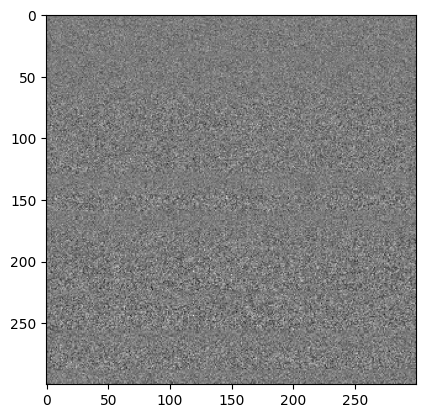

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(state_dict["transformer.h.1.attn.c_attn.weight"][:300, :300], cmap="gray")

## Visualize stage 1 training loss

=> Min train loss: 2.779730796813965
=> Min val loss: 3.0000956058502197
Max HellaSwag accuracy: 0.345947022505477


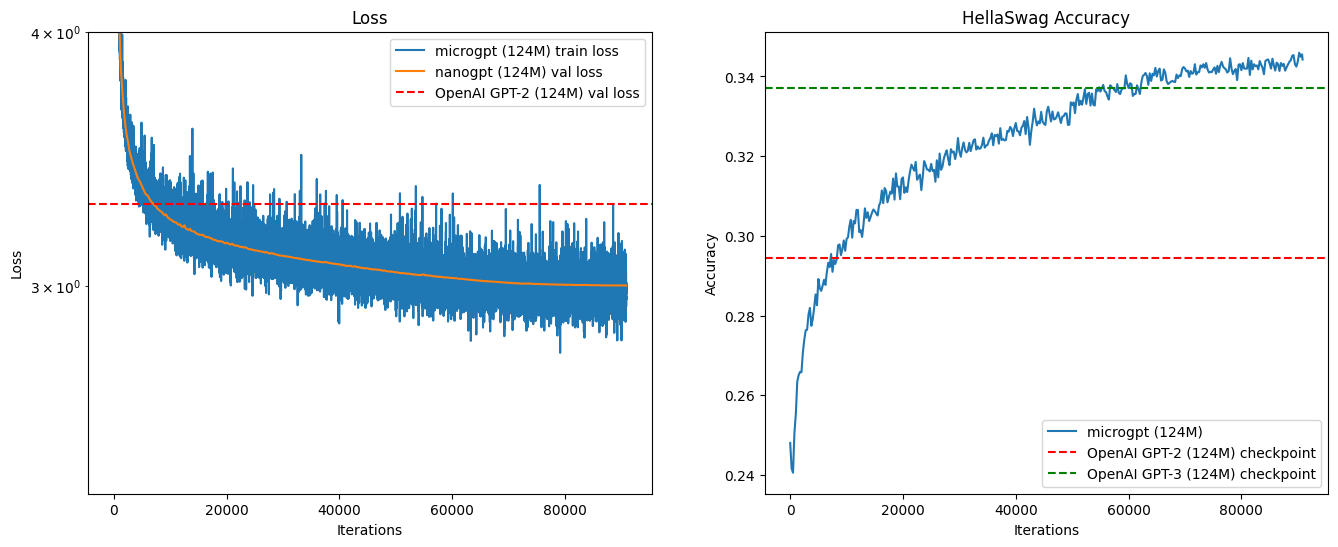

In [19]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

root_dir_path = os.path.dirname(os.path.abspath(""))
with open(os.path.join(root_dir_path, "pretrained/model_stage1/loss.txt")) as f:
    loss_lines = f.readlines()

streams: dict[str, dict[int, float]] = {}
streams["train"] = {}
streams["val"] = {}
streams["hellaswag"] = {}

for loss_line in loss_lines:
    parts = loss_line.split(",")
    iteration = int(parts[0].strip())
    loss = float(parts[1].strip())
    streams["train"][iteration] = loss

with open(os.path.join(root_dir_path, "pretrained/model_stage1/eval.txt")) as f:
    eval_lines = f.readlines()

for eval_line in eval_lines:
    parts = eval_line.split(",")
    iteration = int(parts[0].strip())
    line_type = parts[1].strip()
    if line_type == "val_loss":
        val_loss = float(parts[2].strip())
        streams["val"][iteration] = val_loss
    elif line_type == "hellaswag_accuracy":
        hellaswag_accuracy = float(parts[2].strip())
        streams["hellaswag"][iteration] = hellaswag_accuracy

streams_xy: dict[str, tuple[list[int], list[float]]] = {}
for stream_name in streams:
    items = list(streams[stream_name].items())
    items.sort(key=lambda x: x[0])
    streams_xy[stream_name] = list(zip(*items, strict=True))

model_size = "124M"

plt.figure(figsize=(16, 6))

# Panel 1: losses
plt.subplot(121)
xs, ys = streams_xy["train"]
ys = np.array(ys)
plt.plot(xs, ys, label=f"microgpt ({model_size}) train loss")
print(f"=> Min train loss: {min(ys)}")
xs, ys = streams_xy["val"]
plt.plot(xs, ys, label=f"microgpt ({model_size}) val loss")
print(f"=> Min val loss: {min(ys)}")
plt.axhline(y=3.2924, color="r", linestyle="--", label=f"OpenAI GPT-2 ({model_size}) val loss")
plt.ylim(top=4.0)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss")
plt.legend()

# Panel 2: hellaswag accuracy
plt.subplot(122)
xs, ys = streams_xy["hellaswag"]
ys = np.array(ys)
print(f"=> Max HellaSwag accuracy: {max(ys)}")
plt.plot(xs, ys, label=f"microgpt ({model_size})")
plt.axhline(y=0.294463, color="r", linestyle="--", label=f"OpenAI GPT-2 ({model_size}) checkpoint")
plt.axhline(y=0.337, color="g", linestyle="--", label=f"OpenAI GPT-3 ({model_size}) checkpoint")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("HellaSwag Accuracy")
plt.legend()
plt.show()